<a href="https://colab.research.google.com/github/sheltauro/makemore/blob/main/robust_mlp_with_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Robust NN with batch normalization



In [1]:
import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
read_data = requests.get('https://raw.githubusercontent.com/sheltauro/makemore/main/data/names.txt').content
read_data = read_data.splitlines()
words = [str(rd, 'UTF-8') for rd in read_data]

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# building the dataset

block_size = 3 # context length: how many characters fo we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', ch)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [55]:
n_embd = 10 # dimensionality of the character embedding vectors.
n_hidden = 200 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # The number of characters in the vocabulary.

g = torch.Generator().manual_seed(2147483647)
# Embedding matrix for characters. Compress a character to a size 2 embedding.
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) # using kaiming init
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters.
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_running_mean = torch.zeros((1, n_hidden))
bn_running_std = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12297


In [59]:
h1 = []
max_steps = 200000
for i in range(max_steps + 1):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # picking 32 random elements
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xtr[ix]] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)

  # Linear layer
  hpreact = embcat @ W1 #+ b1 # (N, n_hidden) hidden layer pre-activation

  # Batch normalization
  # ---------------------------------------------------------------
  bn_meani = hpreact.mean(0, keepdim=True) # (1, 200) minibatch mean
  bn_stdi = hpreact.std(0, keepdim=True) # (1, 200) minibatch std
  hpreact = bn_gain * ((hpreact - bn_meani) / bn_stdi) + bn_bias # (1, 200) * (32, 200) + (1, 200)

  with torch.no_grad():
    bn_running_mean = 0.999 * bn_running_mean + 0.001 * bn_meani
    bn_running_std = 0.999 * bn_running_std + 0.001 * bn_stdi
  
  # Non-linearity
  h = torch.tanh(hpreact) # (N, n_hidden) hidden layer
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) # softmax function.

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  # break

# print(loss.item())

      0/ 100000: 2.0006
  10000/ 100000: 2.0941
  20000/ 100000: 2.0030
  30000/ 100000: 2.2627
  40000/ 100000: 2.3447
  50000/ 100000: 1.9278
  60000/ 100000: 2.2163
  70000/ 100000: 2.2766
  80000/ 100000: 1.8670
  90000/ 100000: 1.7859
 100000/ 100000: 1.9388


In [60]:
@torch.no_grad() # This decorator disables gradient tracking.
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  hpreact = bn_gain * ((hpreact - bn_running_mean) / bn_running_std) + bn_bias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y) # softmax function.
  print(split, loss.item())
  return

split_loss('train')
split_loss('val')

train 2.063774585723877
val 2.1221351623535156


## Even more robust neural network

In [109]:
# Let's train a deeper neural network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim) # gain
    self.beta = torch.zeros(dim) # bias
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if (self.training):
      x_mean = x.mean(0, keepdim=True)
      x_var = x.var(0, keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    xhat = ((x - x_mean) / torch.sqrt(x_var + self.eps)) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # dimensionality of the character embedding vectors.
n_hidden = 100 # number of neurons in the hidden layer of the MLP
vocab_size = 27 # The number of characters in the vocabulary.

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),     generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters)) # number of total parameters
for p in parameters:
  p.requires_grad = True

47024


In [110]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # picking 32 random elements
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] 
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss_function


  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item()) # Storing the log loss
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 200000:
    break # AFTER_DEBUG: would take out to run full optimisation




      0/ 200000: 3.3185
  10000/ 200000: 2.5039
  20000/ 200000: 2.1425
  30000/ 200000: 2.1140
  40000/ 200000: 2.3537
  50000/ 200000: 1.7659
  60000/ 200000: 2.2116
  70000/ 200000: 1.8405
  80000/ 200000: 2.3759
  90000/ 200000: 1.9008
 100000/ 200000: 2.1391
 110000/ 200000: 2.0147
 120000/ 200000: 1.9718
 130000/ 200000: 1.8904
 140000/ 200000: 2.0422
 150000/ 200000: 1.9364
 160000/ 200000: 1.8239
 170000/ 200000: 1.8510
 180000/ 200000: 2.3069
 190000/ 200000: 2.2661


layer 2 (      Tanh): mean +0.01, std 0.70, saturated: 12.94%
layer 5 (      Tanh): mean -0.02, std 0.74, saturated: 17.00%
layer 8 (      Tanh): mean -0.02, std 0.76, saturated: 15.88%
layer 11 (      Tanh): mean -0.01, std 0.75, saturated: 17.81%
layer 14 (      Tanh): mean +0.00, std 0.77, saturated: 18.84%


Text(0.5, 1.0, 'activation distribution')

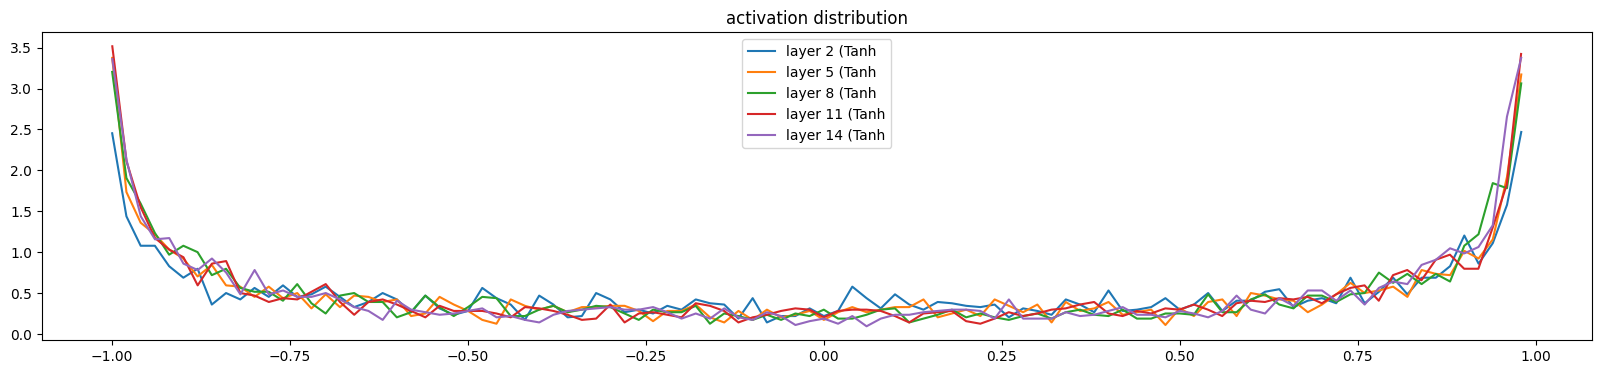

In [111]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.179916e-03
layer 5 (      Tanh): mean +0.000000, std 4.167221e-03
layer 8 (      Tanh): mean -0.000000, std 4.001823e-03
layer 11 (      Tanh): mean -0.000000, std 4.204204e-03
layer 14 (      Tanh): mean +0.000000, std 3.579099e-03


Text(0.5, 1.0, 'gradient distribution')

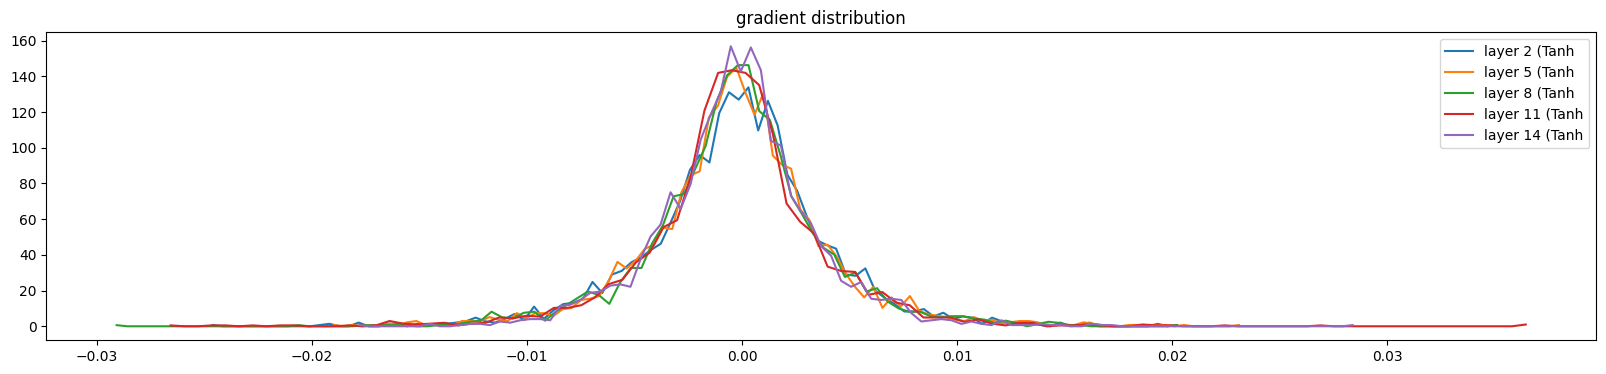

In [112]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.767740e-02 | grad:data ratio 1.621357e-02
weight  (30, 100) | mean +0.000057 | std 8.859633e-03 | grad:data ratio 2.169703e-02
weight (100, 100) | mean -0.000066 | std 6.223241e-03 | grad:data ratio 2.523102e-02
weight (100, 100) | mean +0.000052 | std 6.342814e-03 | grad:data ratio 2.614042e-02
weight (100, 100) | mean +0.000006 | std 6.143306e-03 | grad:data ratio 2.591000e-02
weight (100, 100) | mean +0.000007 | std 5.432408e-03 | grad:data ratio 2.370032e-02
weight  (100, 27) | mean -0.000039 | std 7.616443e-03 | grad:data ratio 2.326488e-02


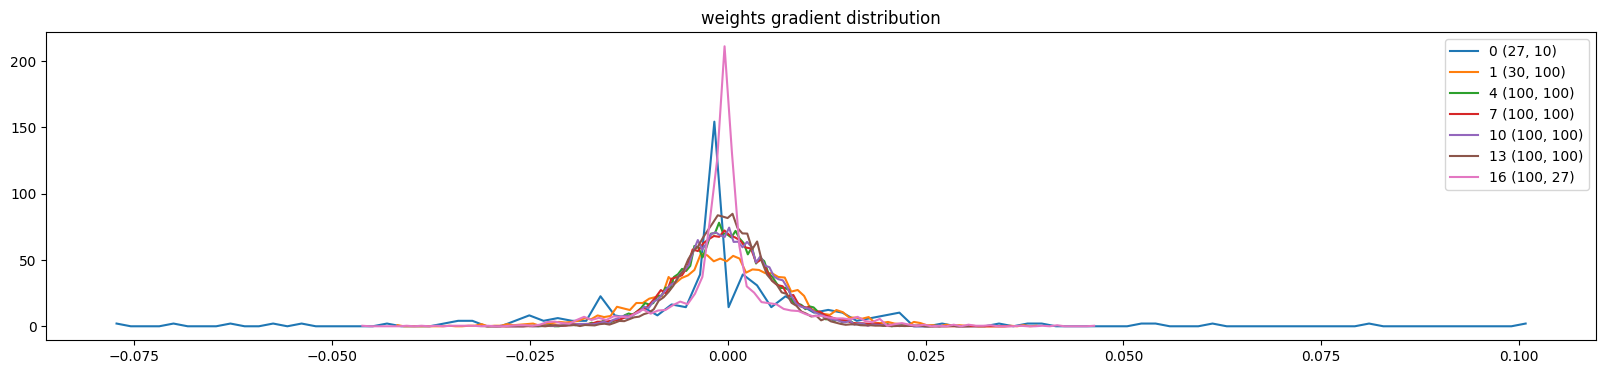

In [113]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

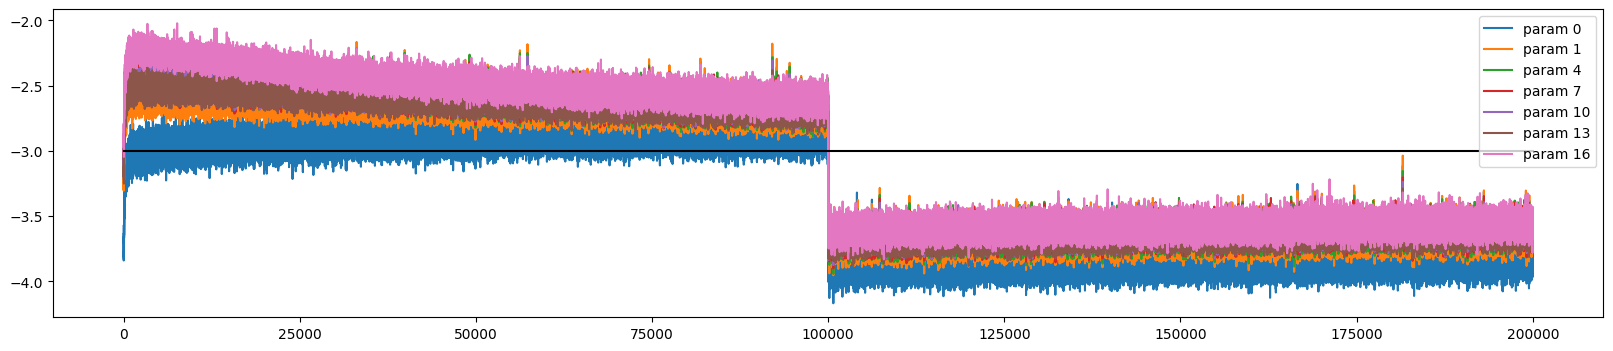

In [114]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [115]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0109925270080566
val 2.0956544876098633


In [116]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
      x = layer(x)
    logits = x
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
mad.
ryla.
remmanieksraeg.
adeeko.
eliah.
milopaleigh.
estanaraelynn.
honelin.
